In [1]:
import pandas as pd
import numpy as np

In [2]:
#For model summary

In [3]:
!pip install -q torchinfo


In [4]:
#Now for deep learning unctionality importing pytorch
import torch

# To define model architectures neural network(nn) module is required from pytorch
from torch import nn

# importing functional utilities from pytorch for activation functions, loss function, etc
import torch.nn.functional as F

# For trainning importing pytorch optimisation module
import torch.optim as optim

# To display model architecture details importing summary function from torchinfo
from torchinfo import summary

# Importing torchdivision for handling image datasets and transformations
import torchvision

# Importing datasets and transforms modules from torchvision
# * Datasets -> it provides access to common datasets like MNIST, CIFAR-10, etc.
# * Transforms -> Used for data preprocessing (eg. normilization, argmentation)

from torchvision import datasets, transforms

# For visulation purpose (like plotting curves, img, confusion)
import matplotlib.pyplot as plt

# For generating random numbers importing random
import random

# To measure execution time of module by importing time module
import time

# Ensures that matplotlib plots appear inline in Jupyter Notebook
%matplotlib inline

Set seed for Reproducibility

In [5]:
def set_seeds():
  # Sets a fixed seed value for reproducibility across multiple libraries (random, NumPy, PyTorch)
  # This ensurres that model training and results remain consistent across different runs.
  SEED_VALUE = 42

  # Set seed for Python's built-in random module
  random.seed(SEED_VALUE)

  #Set seed for NumPy to ensure reproducibility in operations involving randomness
  np.random.seed(SEED_VALUE)

  # Set seed for PyTorch to ensure consistent initialization of weights and other stocha
  torch.manual_seed(SEED_VALUE)

  # If CUDA(NVIDIA GPU support) is available, set additional seeds to control randomness in GPU
  if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED_VALUE) # Set seed for single GPU operations
    torch.cuda.manual_seed_all(SEED_VALUE) # Set seed for multi-GPU operations

    # Ensures deterministic behaviour of cuDNN operations
    torch.backends.cudnn.deterministic = True

    #Ensuring cuNN benchmarking mode can improve training speed for fixed input size
    torch.backends.cudnn.benchmark = True

#Call the function to set the seeds before training to ensure reproducibility
set_seeds()

# **1. Prepare the DataLoader**

    1.1 Input Feature Transformation and Normalization

In [6]:
# Step 1 : Download trainning set without normilization
raw_transform = transforms.Compose([transforms.ToTensor()])

# Step 2 : Download test set without normilization
raw_test_transform = transforms.Compose([transforms.ToTensor()])

# Loading the Fashion MNIST dataset
train_set_raw = datasets.FashionMNIST(root='./data', train=True, download=True, transform=raw_transform)
test_set_raw = datasets.FashionMNIST(root='./data', train=False, download=True, transform=raw_test_transform)

# Step 2 : Compute mean and std from training set
all_pixels = torch.cat([image.view(-1) for image, _ in train_set_raw])
mean = all_pixels.mean()
std = all_pixels.std()

print(f'Calculated mean: {mean}')
print(f'Calculated std: {std}')

# Step 3 : Define the new transformusing the computed mean and std
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,),(std,))
])

# Step 4 : Reload datasets with proper normlization
train_set = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_set = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

print(f'Train set size: {len(train_set)}')
print(f'Test set size: {len(test_set)}')

100%|██████████| 26.4M/26.4M [00:03<00:00, 8.61MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 136kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.59MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.4MB/s]


Calculated mean: 0.2860405743122101
Calculated std: 0.3530242443084717
Train set size: 60000
Test set size: 10000


To avoid the MLP network from learning the sequence pattern in the dataset we will shuffle the train dataset. A batch size is determined based on the compute resource available. As this is a relatively less compute intensive training we can set the batch_size = 64.

In [7]:
# Defining data loaders for training and testing datasets

train_loader = torch.utils.data.DataLoader(train_set, shuffle=True, batch_size=64)

test_loader = torch.utils.data.DataLoader(test_set, shuffle=False, batch_size=64)


The Fashion MNIST contains 10 classes as follows:

Label   Description

0       T-shirt/top

1       Trouser

2       Pullover

3       Dress

4       Coat

5       Sandal

6       Shirt

7       Sneaker

8       Bag

9       Ankle boot

In [8]:
# class to index mapping
class_mapping = {
    0: "T-shirt/top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle boot"
}

# 2. Dataset Visualization

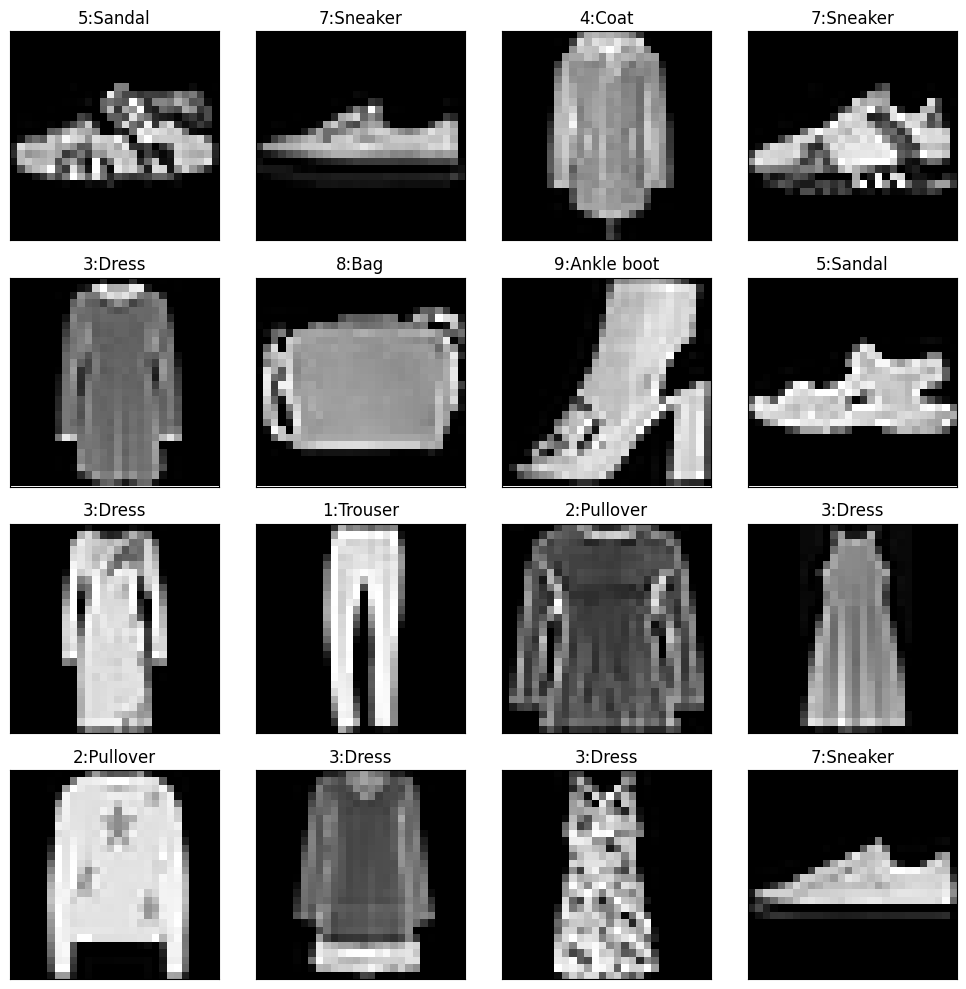

In [9]:
def visualize_images(train_loader, num_images = 20):
  # Function to visualize a batch of images from the training loader.

  # Parameters :
  # trainloader : DataLoader
  #     Pytorch DataLoader containing training images and labels.
  # num_images : int, optional
  #   The number of images to display (default is 20).
  fig = plt.figure(figsize=(10,10)) # Create a figure with a fixed size

  # Retrive the first batch of images and labels from the trainloader
  images, labels = next(iter(train_loader))

  # Define the number of rows and calculate columns dynamically for subplots
  num_rows = 4 # Fixed  number of rows for the grid
  num_cols = int(np.ceil(num_images / num_rows)) # Calculate the required columns

  #Loop through the images up to the specified number
  for idx in range(min(num_images, len(images))):
    image, label = images[idx], labels[idx] #Extract individual image and label

    # Creae a subplot for each image
    ax = fig.add_subplot(num_rows, num_cols, idx + 1, xticks=[], yticks=[])

    # Display the image, ensuring grayscale images are displayed correctly
    ax.imshow(np.squeeze(image), cmap="gray")

    # Set the title to show the label and its corresponding class name
    ax.set_title(f"{label.item()}:{class_mapping[label.item()]}")

  #Adjust subplot layout for better spacing
  plt.tight_layout()

  # Display the figure
  plt.show()

# Defining data loaders for training and testing datasets
visualize_images(train_loader, num_images = 16) # call the function with train_loader


# 3. Multi Layer Perceptron Model Implementation

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    """
    A Multi Layer Perceptron (MLP) model for classification tasks.
    This MLP consists of five fully connected layers with batch normalization,
    ReLU activations, and dropout for regularization.
    """
    def __init__(self, num_classes):
        """
        Initializes the MLP model with the given number of output classes.

        Parameters:
        num_classes (int): The number of output classes for classification.
        """
        super(MLP, self).__init__()

        # Fully connected layers with decreasing number of neurons
        self.fc0 = nn.Linear(28 * 28, 512)     # Input layer: 784 (flattened image) -> 512 neurons
        self.bn0 = nn.BatchNorm1d(512)         # BatchNorm for stability
        self.fc1 = nn.Linear(512, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.fc4 = nn.Linear(64, num_classes)
        self.bn4 = nn.BatchNorm1d(num_classes)

        # Dropout layer to prevent overfitting
        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        """
        Forward pass through the network.

        Parameters:
        x : torch.Tensor
            Input tensor of shape (batch_size, 1, 28, 28) representing images.

        Returns:
        torch.Tensor
            Output tensor of shape (batch_size, num_classes) representing class scores.
        """
        x = x.view(x.shape[0], -1)  # Flatten image to (batch_size, 784)

        x = F.relu(self.bn0(self.fc0(x)))
        x = self.dropout(x)

        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)

        x = F.relu(self.bn3(self.fc3(x)))
        x = F.log_softmax(self.bn4(self.fc4(x)), dim=1)  # Log probabilities
        return x

# Create the model for 10 output classes (like MNIST digits 0–9)
mlp_model = MLP(num_classes=10)


* Parameters and output shapes

In [11]:
# A dummy input size of (B, C, H, W) = (1, 1, 28, 28) is passed
from torchinfo import summary
print(summary(mlp_model, input_size=(1, 1, 28, 28)))



Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [1, 10]                   --
├─Linear: 1-1                            [1, 512]                  401,920
├─BatchNorm1d: 1-2                       [1, 512]                  1,024
├─Dropout: 1-3                           [1, 512]                  --
├─Linear: 1-4                            [1, 256]                  131,328
├─BatchNorm1d: 1-5                       [1, 256]                  512
├─Linear: 1-6                            [1, 128]                  32,896
├─BatchNorm1d: 1-7                       [1, 128]                  256
├─Dropout: 1-8                           [1, 128]                  --
├─Linear: 1-9                            [1, 64]                   8,256
├─BatchNorm1d: 1-10                      [1, 64]                   128
├─Linear: 1-11                           [1, 10]                   650
├─BatchNorm1d: 1-12                      [1, 10]             

**3.1 Training Configuration**

In [12]:
# Define loss function
criterion = F.nll_loss # Negative Log Likelihood Loss, commonly used for classification tasks

# Define the optimizer
optimizer = optim.Adam(mlp_model.parameters(), lr=1e-2) # Adam optimizer with learning rate of 0.01

# Number of epochs for training
num_epochs = 40 # The model will train for 40 complete passes over the dataset

# Select the device for computation (GPU if available, otherwise CPU)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu" # Auto,atically choose the best available hardware

**3.2 Model Training**

In [13]:
def train(model, train_loader, criterion, optimizer, device):
  """
  Trains a PyTorch model for one epoch using the provided training data.

  Parameters:
  model (torch.nn.Module): The PyTorch model to be trained.
  train_loader (torch.utils.data.DataLoader): DataLoader containing training data.
  criterion (torch.nn.Module): The loss function to be used for training.
  optimizer : torch.optim.Optimizer
    Optimizer used for updating model weights (eg Adam, SGD)
  DEVICE : str
    Device to run the training on ("cuda" or "cpu").

  Returns:
  float: The average training loss for the epoch.
  accuracy : float
    The percentage of correctly classified images in the training set.
  """

  # Set model to training mode
  model.train()

  # Move model to the specified device (GPU/CPU)
  model.to(DEVICE)

  # Initialize variables to track loss and accuracy
  running_loss = 0 # Accumulates the total loss for averaging
  correct_predictions = 0 # Counts the number of correct predictions
  total_samples = 0 # Tracks the total number of processed samples

  # Iterate over the training dataset
  for images, labels in train_loader:
    # Move images and labels to the specified device (GPU/CPU)
    images, labels = images.to(DEVICE), labels.to(DEVICE)

    # Zero the gradients of the optimizer
    optimizer.zero_grad()

    # Forward pass: Compute predictions for the input
    outputs = model(images)

    # Calculate the loss between predicted and true labels
    loss = criterion(outputs, labels)

    # Backward pass: Compute gradients of the loss with respect to model parameters
    loss.backward()

    # Update model weights using optimizer
    optimizer.step()

    # Accumulate loss for averaging
    running_loss += loss.item() * images.size(0)

    # Calculate accuracy by comparing predicted labels to true labels
    _, predicted = torch.max(outputs, 1)
    correct_predictions += (predicted == labels).sum().item()
    total_samples += labels.size(0)

  # Calculate average loss and accuracy for the epoch
  average_loss = running_loss / total_samples
  accuracy = 100 * correct_predictions / total_samples

  return average_loss, accuracy # Return average loss and accuracy after one tranining



In [14]:
# def test(model, test_loader, criterion, optimizer, DEVICE):
#   """
#   Evaluates the given model on the test dataset.

#   Parameters:
#   model (torch.nn.Module): The PyTorch model to be evaluated.
#   test_loader (torch.utils.data.DataLoader): DataLoader containing test data.
#   criterion (torch.nn.Module): The loss function to be used for evaluation.
#   optimizer : torch.optim.Optimizer
#     Optimizer used for updating model weights (eg Adam, SGD)
#   DEVICE : str
#     Device to run the training on ("cuda" or "cpu").

#   Returns:
#   float: The average test loss for the epoch.
#   accuracy : float
#     The percentage of correctly classified images in the test set.
#   """

#   # Set model to testing mode
#   model.test()

#   # Move model to the specified device (GPU/CPU)
#   model.to(DEVICE)

#   # Initialize variables to track loss and accuracy
#   running_loss = 0 # Accumulates the total loss for averaging
#   correct_predictions = 0 # Counts the number of correct predictions
#   total_samples = 0 # Tracks the total number of processed samples

#   # Disable gradient computation to save memory and speed up interface
#   with torch.no_grad():
#   # Iterate over the training dataset
#     for images, labels in test_loader:
#     # Move images and labels to the specified device (GPU/CPU)
#       images, labels = images.to(DEVICE), labels.to(DEVICE)

#     # Zero the gradients of the optimizer
#       optimizer.zero_grad()

#     # Forward pass: Compute predictions for the input
#       outputs = model(images)

#     # Calculate the loss between predicted and true labels
#       loss = criterion(outputs, labels)

#     # Accumulate loss for averaging
#       running_loss += loss.item() * images.size(0)

#     # Calculate accuracy by comparing predicted labels to true labels
#       _, predicted = torch.max(outputs, 1)
#       correct_predictions += (predicted == labels).sum().item()
#     total_samples += labels.size(0)

#   # Calculate average loss and accuracy for the epoch
#   average_loss = running_loss / total_samples
#   accuracy = 100 * correct_predictions / total_samples

#   return average_loss, accuracy # Return average loss and accuracy after one tranining

def test(model, test_loader, criterion, DEVICE):
    """
    Evaluates the given model on the test dataset.

    Parameters:
    model (torch.nn.Module): The PyTorch model to be evaluated.
    test_loader (torch.utils.data.DataLoader): DataLoader containing test data.
    criterion (torch.nn.Module): The loss function to be used for evaluation.
    DEVICE : str
      Device to run the training on ("cuda" or "cpu").

    Returns:
    float: The average test loss for the epoch.
    accuracy : float
      The percentage of correctly classified images in the test set.
    """

    # Set model to evaluation mode
    model.eval()

    # Move model to the specified device (GPU/CPU)
    model.to(DEVICE)

    # Initialize variables to track loss and accuracy
    running_loss = 0
    correct_predictions = 0
    total_samples = 0

    # Disable gradient computation to save memory and speed up inference
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            outputs = model(images)

            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)

            _, predicted = torch.max(outputs, 1)
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    average_loss = running_loss / total_samples
    accuracy = 100 * correct_predictions / total_samples

    return average_loss, accuracy


Training 40 epochs

In [15]:
def main(model, train_loader, test_loader, num_epochs=5, DEVICE='cpu'):
    """
    Main training and testing loop for a deep learning model.

    Parameters:
    - model: The PyTorch model to train.
    - train_loader: DataLoader for training data.
    - test_loader: DataLoader for test/validation data.
    - criterion: Loss function.
    - optimizer: Optimizer (e.g., SGD, Adam).
    - num_epochs: Number of training epochs (default = 5).
    - DEVICE: Device to run the model on ('cpu' or 'cuda').
    """

    # Lists to store loss and accuracy values for plotting
    train_losses, test_losses = [], []
    train_accuracies, test_accuracies = [], []

    # Training loop for multiple epochs
    for epoch in range(num_epochs):
        # Train the model for one epoch
        train_loss, train_accuracy = train(model, train_loader, criterion, optimizer, DEVICE)

        # Validate the model after training
        test_loss, test_accuracy = test(model, test_loader, criterion, DEVICE)

        # Store losses and accuracies for analysis
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        # Print training progress for each epoch
        print(f"Epoch {epoch + 1:02d}/{num_epochs}: "
              f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, "
              f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    # Plot training and validation loss
    plt.figure(figsize=(12, 5))

    # Subplot 1: Loss over epochs
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    # Subplot 2: Accuracy over epochs
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(test_accuracies, label='Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    # Display the plots
    plt.show()


Epoch 01/40: Train Loss: 0.5922, Train Accuracy: 80.09%, Test Loss: 0.4421, Test Accuracy: 84.06%
Epoch 02/40: Train Loss: 0.4531, Train Accuracy: 84.19%, Test Loss: 0.3902, Test Accuracy: 85.89%
Epoch 03/40: Train Loss: 0.4102, Train Accuracy: 85.69%, Test Loss: 0.3674, Test Accuracy: 86.59%
Epoch 04/40: Train Loss: 0.3823, Train Accuracy: 86.23%, Test Loss: 0.3590, Test Accuracy: 86.94%
Epoch 05/40: Train Loss: 0.3646, Train Accuracy: 87.01%, Test Loss: 0.3405, Test Accuracy: 88.03%
Epoch 06/40: Train Loss: 0.3490, Train Accuracy: 87.52%, Test Loss: 0.3324, Test Accuracy: 87.90%
Epoch 07/40: Train Loss: 0.3328, Train Accuracy: 88.05%, Test Loss: 0.3372, Test Accuracy: 88.06%
Epoch 08/40: Train Loss: 0.3251, Train Accuracy: 88.20%, Test Loss: 0.3207, Test Accuracy: 88.17%
Epoch 09/40: Train Loss: 0.3121, Train Accuracy: 88.80%, Test Loss: 0.3313, Test Accuracy: 88.04%
Epoch 10/40: Train Loss: 0.3029, Train Accuracy: 89.04%, Test Loss: 0.3081, Test Accuracy: 88.72%
Epoch 11/40: Train L

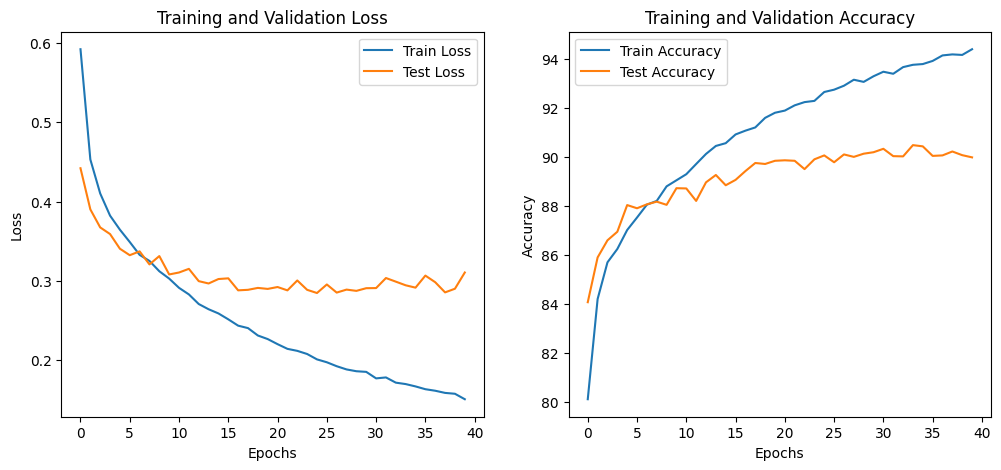

In [ ]:
main(mlp_model, train_loader, test_loader, num_epochs=num_epochs, DEVICE=DEVICE)
